In [1]:
# Normalize /mnt/data/legal-contract.jsonl -> /content/qa_clean_legal.jsonl
# Supports either {"user","assistant"} OR {"messages":[{"role":"user|assistant","content":...}, ...]}

import json, re
from collections import Counter
from pathlib import Path

IN_JSONL  = "/content/legal-contract.jsonl"   # <- change to your path if needed
OUT_JSONL = "/content/qa_clean_legal.jsonl"
Path(OUT_JSONL).parent.mkdir(parents=True, exist_ok=True)

def get_from_messages(obj):
    msgs = obj.get("messages")
    if not isinstance(msgs, list) or not msgs:
        return None, None
    # last user + first assistant after it
    user_text = None
    for m in reversed(msgs):
        if isinstance(m, dict) and m.get("role","").lower() == "user":
            user_text = str(m.get("content","")).strip()
            break
    if not user_text:
        return None, None
    seen_user = False
    for m in msgs:
        if isinstance(m, dict) and m.get("role","").lower() == "user" and str(m.get("content","")).strip() == user_text:
            seen_user = True
            continue
        if seen_user and isinstance(m, dict) and m.get("role","").lower() == "assistant":
            return user_text, str(m.get("content","")).strip()
    return user_text, None

def extract_qa(obj):
    # 1) messages schema
    u, a = get_from_messages(obj)
    if u and a: return u, a

    # 2) direct key variants
    for uk, ak in [
        ("user","assistant"), ("question","answer"),
        ("input","output"), ("prompt","response"),
        ("instruction","output"), ("human","bot"),
        ("User","Assistant")
    ]:
        u = str(obj.get(uk,"") or "").strip()
        a = str(obj.get(ak,"") or "").strip()
        if u and a: return u, a

    # 3) free-text with tags
    t = str(obj.get("text","") or "").strip()
    if t:
        m = re.search(r"User:\s*(.+?)\s*Assistant:\s*(.+)", t, flags=re.S|re.I)
        if m: return m.group(1).strip(), m.group(2).strip()
    return None, None

pairs = []
key_counter = Counter()
with open(IN_JSONL, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line: continue
        try:
            obj = json.loads(line)
        except Exception:
            continue
        key_counter.update(obj.keys())
        u, a = extract_qa(obj)
        if u and a:
            pairs.append({"prompt": f"User: {u}\nAssistant:", "completion": a})

print("Top keys seen:", key_counter.most_common(20))
print("Valid pairs:", len(pairs))

if not pairs:
    raise ValueError("No Q/A pairs found. Please show 2–3 raw lines so I can adapt the parser.")

with open(OUT_JSONL, "w", encoding="utf-8") as w:
    for r in pairs:
        w.write(json.dumps(r, ensure_ascii=False) + "\n")

print("Wrote cleaned JSONL to:", OUT_JSONL)


Top keys seen: [('messages', 1058)]
Valid pairs: 1058
Wrote cleaned JSONL to: /content/qa_clean_legal.jsonl


In [2]:
# LoRA SFT for legal Q&A — plain Transformers + PEFT (version-friendly)
# No evaluation_strategy arg; we do a manual evaluation after training.

!pip -q install "transformers>=4.31.0" "datasets>=2.14.0" "peft>=0.6.0" accelerate

import random
from dataclasses import dataclass
from typing import List, Dict
import torch
from torch.utils.data import Dataset
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model

SEED = 42
random.seed(SEED); torch.manual_seed(SEED)

DATA_JSONL = "/content/qa_clean_legal.jsonl"     # from step 1
MODEL_NAME = "facebook/opt-1.3b"                 # try a smallish model; you can start with opt-350m
OUTPUT_DIR = "/content/legal_lora_out"
MAX_LEN = 1024
BATCH = 2
EPOCHS = 4
LR = 2e-4

# ---------- Load & split ----------
ds = load_dataset("json", data_files=DATA_JSONL, split="train")
splits = ds.train_test_split(test_size=0.1, seed=SEED)
train_ds, val_ds = splits["train"], splits["test"]

# ---------- Tokenizer & base ----------
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tok.pad_token is None:
    tok.pad_token = tok.eos_token
base = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

# ---------- Apply LoRA (OPT-style targets; adjust for Llama/Mistral if you switch base) ----------
lora_cfg = LoraConfig(
    r=16, lora_alpha=32, lora_dropout=0.05, bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj","k_proj","v_proj","out_proj","fc1","fc2"]
)
model = get_peft_model(base, lora_cfg)

# ---------- Dataset that masks the prompt (completion-only loss) ----------
class ChatDataset(Dataset):
    def __init__(self, hf_split, tokenizer: AutoTokenizer, max_len: int):
        self.data = hf_split
        self.tok = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        ex = self.data[idx]
        prompt = ex["prompt"]           # "User: ...\nAssistant:"
        completion = ex["completion"]   # assistant answer (legal)
        # tokenize separately (no special tokens) and then combine
        prompt_ids = self.tok(prompt, add_special_tokens=False)["input_ids"]
        completion_ids = self.tok(" " + completion, add_special_tokens=False)["input_ids"]
        input_ids = prompt_ids + completion_ids + [self.tok.eos_token_id]
        labels    = [-100]*len(prompt_ids) + completion_ids + [self.tok.eos_token_id]
        # left-truncate to fit max_len
        if len(input_ids) > self.max_len:
            input_ids = input_ids[-self.max_len:]
            labels    = labels[-self.max_len:]
        attention_mask = [1]*len(input_ids)
        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long),
        }

train_torch = ChatDataset(train_ds, tok, MAX_LEN)
val_torch   = ChatDataset(val_ds, tok, MAX_LEN)

# ---------- Simple pad collator ----------
@dataclass
class PadCollator:
    pad_id: int
    def __call__(self, batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
        maxlen = max(x["input_ids"].size(0) for x in batch)
        def pad_vec(v, pad_val):
            pad_len = maxlen - v.size(0)
            return torch.cat([v, torch.full((pad_len,), pad_val, dtype=v.dtype)], dim=0) if pad_len>0 else v
        input_ids = torch.stack([pad_vec(x["input_ids"], self.pad_id) for x in batch])
        attention = torch.stack([pad_vec(x["attention_mask"], 0) for x in batch])
        labels    = torch.stack([pad_vec(x["labels"], -100) for x in batch])
        return {"input_ids": input_ids, "attention_mask": attention, "labels": labels}

collator = PadCollator(pad_id=tok.pad_token_id)

# ---------- Train ----------
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH,
    per_device_eval_batch_size=BATCH,
    gradient_accumulation_steps=1,
    learning_rate=LR,
    num_train_epochs=EPOCHS,
    logging_steps=20,
    save_steps=200,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    data_collator=collator,
    train_dataset=train_torch,
    eval_dataset=val_torch,   # manual eval after training
)

trainer.train()
metrics = trainer.evaluate()
print("Eval metrics:", metrics)

# ---------- Save adapters ----------
trainer.model.save_pretrained(OUTPUT_DIR)
tok.save_pretrained(OUTPUT_DIR)
print("Saved LoRA adapters to:", OUTPUT_DIR)

# ---------- Inference helper ----------
from peft import PeftModel
def legal_assistant(user_text, max_new_tokens=256, do_sample=False, temperature=0.7):
    base = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
    peft = PeftModel.from_pretrained(base, OUTPUT_DIR)
    peft.eval()
    # Optional domain system preface to keep answers scoped & safe
    system_hint = ("You are a legal information assistant. You provide general information, "
                   "not legal advice. For specific cases, advise consulting a qualified attorney.\n")
    prompt = f"{system_hint}User: {user_text}\nAssistant:"
    inputs = tok(prompt, return_tensors="pt").to(peft.device)
    with torch.no_grad():
        out = peft.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=do_sample, temperature=temperature)
    text = tok.decode(out[0], skip_special_tokens=True)
    return text.split("Assistant:")[-1].strip()

print(legal_assistant("Summarize key risks commonly found in SaaS MSAs."))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Step,Training Loss
20,2.008900
40,1.783500
60,1.701400
80,1.810500
100,1.781800
120,1.776100
140,1.778400
160,1.700700
180,1.691000
200,1.702300


Eval metrics: {'eval_loss': 1.4174041748046875, 'eval_runtime': 4.0557, 'eval_samples_per_second': 26.136, 'eval_steps_per_second': 13.068, 'epoch': 4.0}
Saved LoRA adapters to: /content/legal_lora_out


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Key risks commonly found in SaaS MSAs include security vulnerabilities, data breaches, and service interruptions. To address these risks, it is important to have a comprehensive security strategy in place, including continuous monitoring, patching, and governance policies. Additionally, implement best practices such as multi-factor authentication, encryption, and data protection.


In [3]:
print(legal_assistant("What kind of information is typically included in an 8-K filing?"))

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


An 8-K filing typically includes information about significant corporate events such as mergers and acquisitions, changes in executive leadership, bankruptcy or receivership, amendments to articles of incorporation or bylaws, financial restatements, or other material events that could affect shareholders or the company's financial status.


In [4]:
print(legal_assistant("What kind of information is in a 8-K filing?"))

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


An 8-K filing typically includes information about significant corporate events such as mergers and acquisitions, changes in executive leadership, bankruptcy or receivership, amendments to articles of incorporation or bylaws, financial restatements, or other material events that shareholders should be aware of.


Samples: 1000
Prompt length:    mean= 21.8   p95= 33.0
Completion length: mean= 54.4   p95= 94.0
Total length:      mean= 76.2   p95= 122.0


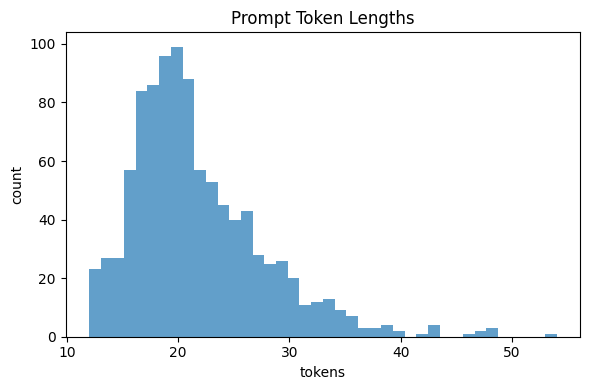

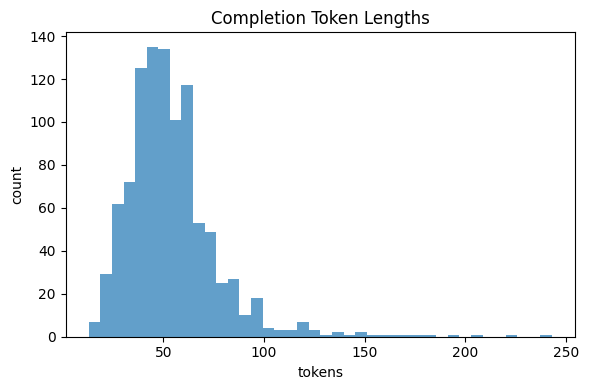

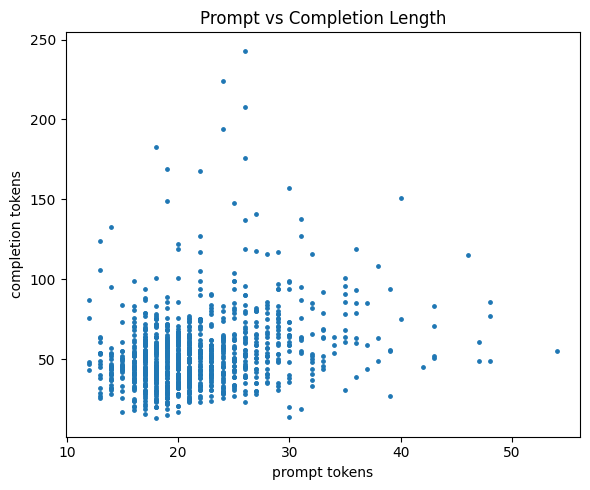


Top 20 unigrams:
            the : 3693
             to : 1409
            and : 1161
             of : 1019
              a : 937
             or : 832
             is : 817
             in : 747
           that : 599
      agreement : 475
            for : 449
             as : 406
             it : 389
        network : 388
      affiliate : 381
       contract : 365
           this : 355
             if : 344
            are : 331
             by : 316

Top 20 bigrams:
                of the : 389
         the agreement : 318
         the affiliate : 301
                to the : 248
          the contract : 224
           the network : 215
                in the : 176
              that the : 151
           the service : 137
                if the : 117
           the parties : 115
               such as : 107
                 it is : 104
                   8 k : 100
                on the : 91
                by the : 86
          both parties : 78
               for the : 74
   

In [7]:
# === Dataset visualizations for cleaned JSONL (prompt/completion) ===
import json, re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from datasets import load_dataset
from transformers import AutoTokenizer

DATA_JSONL = "/content/qa_clean_legal.jsonl"   # or your other cleaned file
BASE_MODEL = "facebook/opt-1.3b"               # same tokenizer used for training
MAX_SHOW = 1000                                # cap for speed in huge sets

ds = load_dataset("json", data_files=DATA_JSONL, split="train")
if len(ds) > MAX_SHOW:
    ds = ds.select(range(MAX_SHOW))

# 1) Tokenization lengths
tok = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)
if tok.pad_token is None:
    tok.pad_token = tok.eos_token

def tok_len(text):
    return len(tok(text, add_special_tokens=False)["input_ids"])

prompt_lens = [tok_len(r["prompt"]) for r in ds]
completion_lens = [tok_len(r["completion"]) for r in ds]
total_lens = [p + c for p, c in zip(prompt_lens, completion_lens)]

print(f"Samples: {len(ds)}")
print("Prompt length:    mean=", np.mean(prompt_lens).round(1), "  p95=", np.percentile(prompt_lens,95).round(1))
print("Completion length: mean=", np.mean(completion_lens).round(1), "  p95=", np.percentile(completion_lens,95).round(1))
print("Total length:      mean=", np.mean(total_lens).round(1), "  p95=", np.percentile(total_lens,95).round(1))

# Hist: prompt / completion token lengths
plt.figure(figsize=(6,4))
plt.hist(prompt_lens, bins=40, alpha=0.7)
plt.title("Prompt Token Lengths")
plt.xlabel("tokens"); plt.ylabel("count")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.hist(completion_lens, bins=40, alpha=0.7)
plt.title("Completion Token Lengths")
plt.xlabel("tokens"); plt.ylabel("count")
plt.tight_layout(); plt.show()

# Scatter: prompt vs completion length (spot outliers)
plt.figure(figsize=(6,5))
plt.scatter(prompt_lens, completion_lens, s=6)
plt.title("Prompt vs Completion Length")
plt.xlabel("prompt tokens"); plt.ylabel("completion tokens")
plt.tight_layout(); plt.show()

# 2) Simple vocabulary stats (top unigrams/bigrams in completions)
def simple_tokens(s):
    # very light tokenizer for counts (separate from model tokenizer)
    return re.findall(r"[A-Za-z0-9_]+", s.lower())

uni = Counter()
bi  = Counter()
for r in ds:
    tt = simple_tokens(r["completion"])
    uni.update(tt)
    bi.update(zip(tt, tt[1:]))

print("\nTop 20 unigrams:")
for w,c in uni.most_common(20):
    print(f"{w:>15s} : {c}")

print("\nTop 20 bigrams:")
for (w1,w2),c in bi.most_common(20):
    print(f"{w1+' '+w2:>22s} : {c}")
